<a href="https://colab.research.google.com/github/WillianRullian/Residencia-/blob/main/CNN_1_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação de Imagens com CNNs - CUHK Face Sketch Database

Este notebook implementa um modelo de rede neural convolucional (CNN) para classificar as imagens do dataset CUHK Face Sketch Database (CUFS) de acordo com o sexo biológico (masculino ou feminino).

As etapas incluem:
1. **Preparação dos Dados**: Download, anotação e pré-processamento.
2. **Divisão do Dataset**: Treinamento, validação e teste.
3. **Criação do Modelo CNN**: Implementação de uma rede personalizada.
4. **Análise dos Resultados**: Avaliação com métricas como F1-Score, ROC e AUC-ROC.


In [ ]:
# Bibliotecas padrão para manipulação de dados e arquivos
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ferramentas do Google Colab e widgets interativos
from google.colab import files
from ipywidgets import VBox, HBox, Button, Output
from IPython.display import display

# TensorFlow e Keras para manipulação de imagens e redes neurais
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

# Scikit-learn para manipulação de dados e avaliação de modelos
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, roc_curve, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)

sns.set(style='whitegrid')

In [ ]:
# Baixar e descompactar dataset
!pip install kaggle --quiet
!kaggle datasets download -d arbazkhan971/cuhk-face-sketch-database-cufs --force
!unzip -oq "cuhk-face-sketch-database-cufs.zip"

# Verificar número de arquivos encontrados
photos_folder = "photos"
file_list = os.listdir(photos_folder)
print(f"Total de imagens encontradas: {len(file_list)}")


Dataset URL: https://www.kaggle.com/datasets/arbazkhan971/cuhk-face-sketch-database-cufs
License(s): copyright-authors
 99% 112M/113M [00:04<00:00, 32.9MB/s]
100% 113M/113M [00:04<00:00, 26.3MB/s]
Total de imagens encontradas: 188


In [ ]:
# Caminho do arquivo CSV
save_path = "labels.csv"

# Variáveis globais
labeled_files = []
labels = []

# Função para fazer upload do arquivo rotulado
def upload_progress():
    uploaded = files.upload()  # Abrir janela para upload do arquivo CSV
    if uploaded:
        file_name = list(uploaded.keys())[0]
        try:
            data = pd.read_csv(file_name)
            if "filename" in data.columns and "label" in data.columns and not data.empty:
                # Substituir os arquivos salvos
                global labeled_files, labels
                labeled_files = data["filename"].tolist()
                labels = data["label"].tolist()
                # Substituir o arquivo salvo
                data.to_csv(save_path, index=False)
                print(f"Arquivo '{file_name}' carregado com sucesso. {len(labeled_files)} rótulos disponíveis.")
            else:
                print("Erro: O arquivo não possui as colunas esperadas ('filename' e 'label') ou está vazio.")
        except Exception as e:
            print(f"Erro ao ler o arquivo: {e}")
    else:
        print("Nenhum arquivo foi carregado.")

# Função para pular a célula (apaga progresso)
def skip_cell():
    if os.path.exists(save_path):
        os.remove(save_path)
    global labeled_files, labels
    labeled_files = []
    labels = []
    print("Progresso anterior apagado. A rotulação manual será iniciada na próxima célula.")

# Interface para upload ou pular
print("Deseja fazer upload de um arquivo rotulado existente ou iniciar uma nova rotulação?")
upload_button = Button(description="Fazer Upload do Arquivo Rotulado", style={"button_color": "orange"})
skip_button = Button(description="Pular e Iniciar Nova Rotulação", style={"button_color": "red"})

upload_button.on_click(lambda b: upload_progress())
skip_button.on_click(lambda b: skip_cell())

display(HBox([upload_button, skip_button]))


Deseja fazer upload de um arquivo rotulado existente ou iniciar uma nova rotulação?


Saving labels.csv to labels.csv
Arquivo 'labels.csv' carregado com sucesso. 170 rótulos disponíveis.
Progresso anterior apagado. A rotulação manual será iniciada na próxima célula.


Saving labels.csv to labels (4).csv
Arquivo 'labels (4).csv' carregado com sucesso. 170 rótulos disponíveis.


In [ ]:
# Verificar número de arquivos encontrados
print(f"Total de imagens encontradas: {len(file_list)}")

# Diretório das imagens
photos_folder = "photos"
file_list = os.listdir(photos_folder)

# Salvar progresso
save_path = "labels.csv"
if os.path.exists(save_path):
    data = pd.read_csv(save_path)
    labeled_files = data["filename"].tolist()
    labels = data["label"].tolist()
    print(f"Continuando do arquivo existente com {len(labeled_files)} rótulos.")
else:
    labeled_files = []
    labels = []

# Criar widgets interativos
output = Output()
label_buttons = HBox([
    Button(description="Masculino", style={"button_color": "lightblue"}),
    Button(description="Feminino", style={"button_color": "pink"})
])
skip_button = Button(description="Pular", style={"button_color": "lightgray"})
save_button = Button(description="Salvar Progresso", style={"button_color": "green"})

# Variáveis globais para progresso
current_index = 0
current_file = None

# Função para atualizar a exibição da imagem
def show_next_image():
    global current_index, current_file

    # Verificar se há mais imagens para rotular
    if current_index >= len(file_list):
        with output:
            output.clear_output()
            print("Todas as imagens foram rotuladas!")
        return

    # Exibir próxima imagem não rotulada
    current_file = file_list[current_index]
    if current_file in labeled_files:
        current_index += 1
        show_next_image()  # Pular arquivos já rotulados
    else:
        img_path = os.path.join(photos_folder, current_file)
        img = load_img(img_path, target_size=(250, 200))
        with output:
            output.clear_output()
            plt.imshow(img)
            plt.axis("off")
            plt.title(f"Arquivo: {current_file}")
            plt.show()

# Função para salvar rótulo
def save_label(label):
    global current_index, current_file
    if current_file:
        labeled_files.append(current_file)
        labels.append(label)
        current_index += 1
        show_next_image()

# Funções para botões
def masculino_clicked(b):
    save_label(0)

def feminino_clicked(b):
    save_label(1)

def skip_clicked(b):
    global current_index
    current_index += 1
    show_next_image()

def save_progress(b):
    pd.DataFrame({"filename": labeled_files, "label": labels}).to_csv(save_path, index=False)
    with output:
        output.clear_output()
        print(f"Progresso salvo! Total de imagens rotuladas: {len(labeled_files)}")

# Associar botões às funções
label_buttons.children[0].on_click(masculino_clicked)
label_buttons.children[1].on_click(feminino_clicked)
skip_button.on_click(skip_clicked)
save_button.on_click(save_progress)

# Exibir layout interativo
ui = VBox([output, label_buttons, skip_button, save_button])
display(ui)

# Mostrar a primeira imagem
show_next_image()


Total de imagens encontradas: 188
Continuando do arquivo existente com 170 rótulos.


In [ ]:
# Diretório das imagens e arquivo de rótulos
photos_folder = "photos"
labels_file = "labels.csv"

# Verificar se os arquivos e pastas existem
if not os.path.exists(labels_file):
    raise FileNotFoundError(f"O arquivo {labels_file} não foi encontrado.")
if not os.path.exists(photos_folder):
    raise FileNotFoundError(f"O diretório {photos_folder} não foi encontrado.")

# Carregar os rótulos
data = pd.read_csv(labels_file)

# Exibir os primeiros registros
print("Primeiros registros do arquivo de rótulos:")
print(data.head(20))

# Verificar número total de imagens
print(f"Total de imagens no dataset: {len(data)}")


Primeiros registros do arquivo de rótulos:
         filename  label
0   m1-011-01.jpg      0
1    m-039-01.jpg      0
2    m-065-01.jpg      0
3   m1-037-01.jpg      0
4    m-044-01.jpg      0
5   f1-004-01.jpg      1
6   m1-039-01.jpg      0
7    m-038-01.jpg      0
8    m-099-01.jpg      0
9   m1-005-01.jpg      0
10   m-016-01.jpg      0
11  m1-007-01.jpg      0
12   m-073-01.jpg      1
13   f-043-01.jpg      1
14   f-010-01.jpg      1
15   m-015-01.jpg      0
16   m-085-01.jpg      0
17   m-034-01.jpg      1
18  m1-028-01.jpg      0
19   m-049-01.jpg      0
Total de imagens no dataset: 173


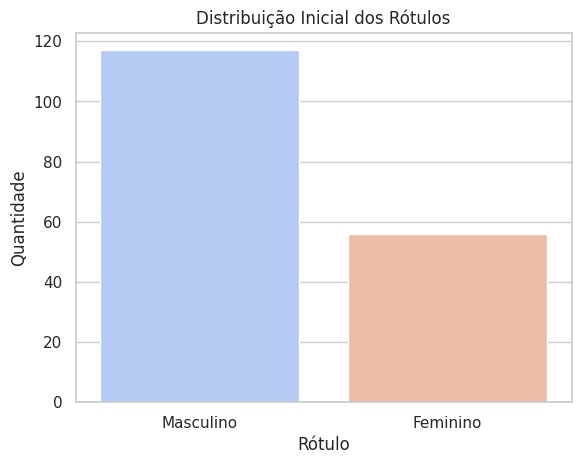

In [ ]:
# Ajuste para evitar o FutureWarning
sns.countplot(data=data, x="label", hue="label", palette="coolwarm", dodge=False, legend=False)
plt.title("Distribuição Inicial dos Rótulos")
plt.xticks([0, 1], ["Masculino", "Feminino"])
plt.ylabel("Quantidade")
plt.xlabel("Rótulo")
plt.show()


In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array

# Função de pré-processamento
def preprocess_image(image_path, target_size=(250, 200)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0  # Normalizar para [0, 1]
    return img_array


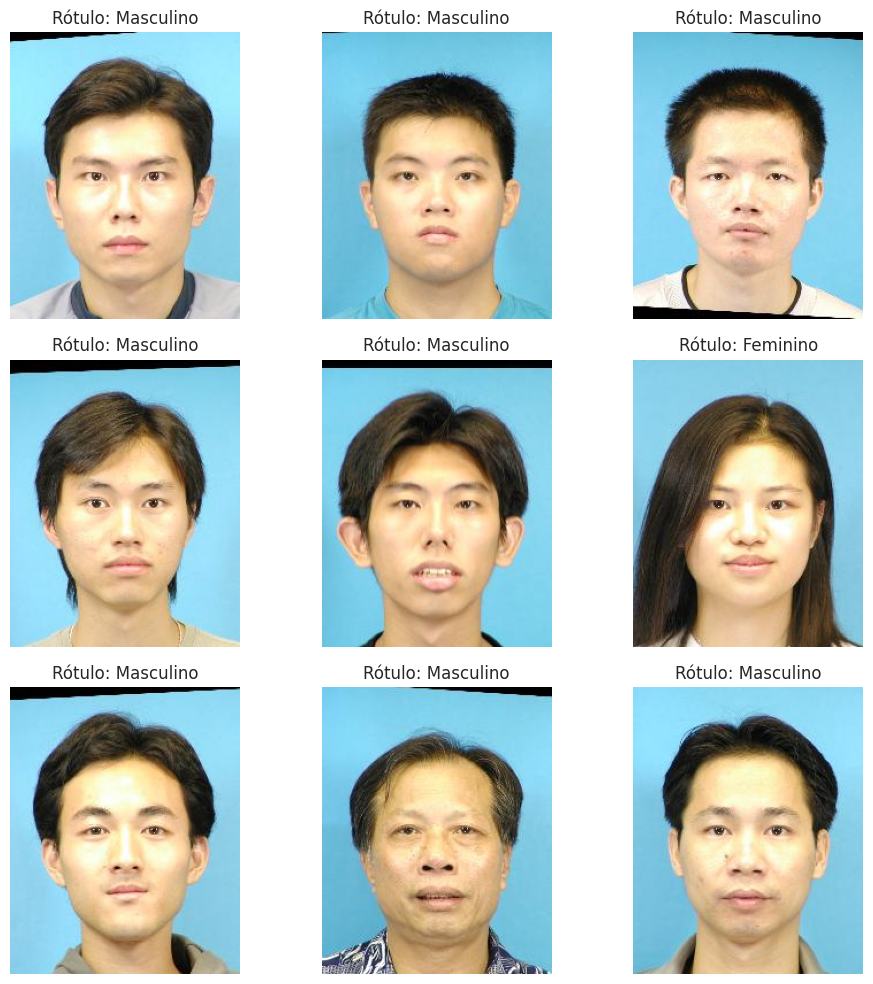

In [ ]:
def plot_images_with_labels(data, folder, num_images=9):
    """Exibe algumas imagens do dataset com seus rótulos."""
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        file_path = os.path.join(folder, data.iloc[i]["filename"])
        img = load_img(file_path, target_size=(250, 200))
        label = data.iloc[i]["label"]

        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(f"Rótulo: {'Feminino' if label == 1 else 'Masculino'}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Exibir imagens com seus rótulos
plot_images_with_labels(data, photos_folder)


Classe majoritária (Masculino): 117
Classe minoritária (Feminino): 56


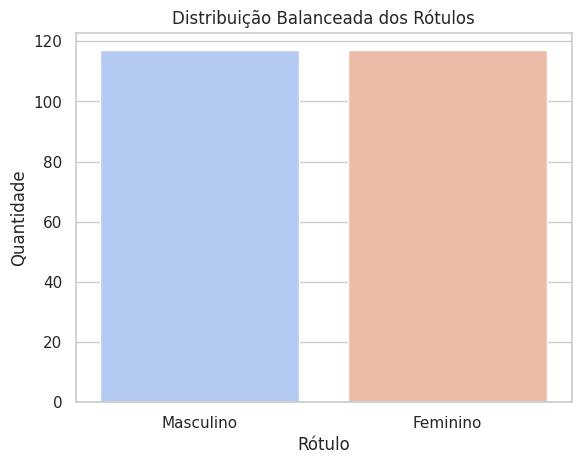

In [ ]:
# Separar classes majoritária e minoritária
majority_class = data[data["label"] == 0]  # Classe Masculino
minority_class = data[data["label"] == 1]  # Classe Feminino

print(f"Classe majoritária (Masculino): {len(majority_class)}")
print(f"Classe minoritária (Feminino): {len(minority_class)}")

# Aplicar oversampling na classe minoritária
minority_upsampled = resample(
    minority_class,
    replace=True,               # Permitir repetição de exemplos
    n_samples=len(majority_class),  # Igualar ao tamanho da classe majoritária
    random_state=23             # Garantir reprodutibilidade
)

# Combinar classes majoritária e minoritária
data_balanced = pd.concat([majority_class, minority_upsampled])

# Embaralhar os dados
data_balanced = data_balanced.sample(frac=1, random_state=23).reset_index(drop=True)

# Verificar a nova distribuição (ajuste para evitar o warning)
sns.countplot(data=data_balanced, x="label", hue="label", palette="coolwarm", dodge=False, legend=False)
plt.title("Distribuição Balanceada dos Rótulos")
plt.xticks([0, 1], ["Masculino", "Feminino"])
plt.ylabel("Quantidade")
plt.xlabel("Rótulo")
plt.show()


In [ ]:
# Pré-processar todas as imagens no dataset balanceado
image_data = []
for idx, row in data_balanced.iterrows():
    img_path = os.path.join(photos_folder, row["filename"])
    image_data.append(preprocess_image(img_path))

# Converter em arrays NumPy
X = np.array(image_data)
y = data_balanced["label"].values

# Confirmar formatos
print(f"Formato de X (imagens): {X.shape}")
print(f"Formato de y (rótulos): {y.shape}")


Formato de X (imagens): (234, 250, 200, 3)
Formato de y (rótulos): (234,)


In [ ]:
# Divisão em treino, validação e teste
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=23)  # 60% treino
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=23)  # 20% validação, 20% teste

# Confirmar tamanhos
print(f"Tamanho do conjunto de treino: {X_train.shape}")
print(f"Tamanho do conjunto de validação: {X_val.shape}")
print(f"Tamanho do conjunto de teste: {X_test.shape}")


Tamanho do conjunto de treino: (140, 250, 200, 3)
Tamanho do conjunto de validação: (47, 250, 200, 3)
Tamanho do conjunto de teste: (47, 250, 200, 3)


In [ ]:
# Definir o modelo
model = Sequential([
    Input(shape=(250, 200, 3)),  # Dimensão da entrada
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Saída binária
])

# Compilar o modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Resumo do modelo
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 248, 198, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 124, 99, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 122, 97, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 61, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 59, 46, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 29, 23, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 101,569 (396.75 KB)

 Trainable params: 101,569 (396.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Definir Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Treinar o modelo
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop]
)


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.4917 - loss: 0.6947 - val_accuracy: 0.5106 - val_loss: 0.6925
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.4634 - loss: 0.7028 - val_accuracy: 0.5106 - val_loss: 0.6944
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.5217 - loss: 0.6894 - val_accuracy: 0.7660 - val_loss: 0.6922
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - accuracy: 0.4393 - loss: 0.6999 - val_accuracy: 0.4894 - val_loss: 0.6924
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.5991 - loss: 0.6863 - val_accuracy: 0.4894 - val_loss: 0.6920
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.6019 - loss: 0.6874 - val_accuracy: 0.4894 - val_loss: 0.6905
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.5776 - loss: 0.6846 - val_accuracy: 0.5106 - val_loss: 0.6887
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.5598 - loss: 0.6917 - val_accuracy: 0.5957 - val_loss: 0.6860
Epoch 9/

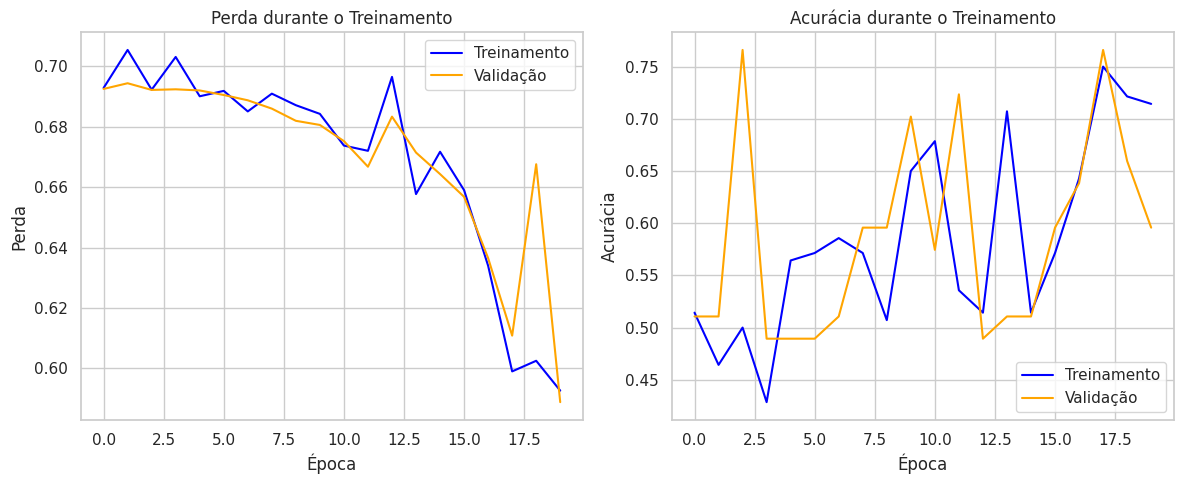

In [ ]:
# Visualizar perda e acurácia durante o treinamento
def plot_training_history(history):
    """Plota os gráficos de perda e acurácia do treinamento e validação."""
    plt.figure(figsize=(12, 5))

    # Perda
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Treinamento', color='blue')
    plt.plot(history.history['val_loss'], label='Validação', color='orange')
    plt.title('Perda durante o Treinamento')
    plt.xlabel('Época')
    plt.ylabel('Perda')
    plt.legend()

    # Acurácia
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Treinamento', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validação', color='orange')
    plt.title('Acurácia durante o Treinamento')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plotar resultados do treinamento
plot_training_history(history)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 386ms/step
ROC-AUC: 0.72


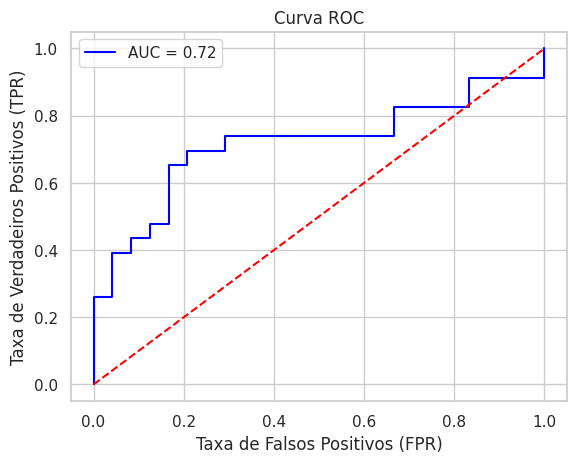

Threshold Ótimo: 0.63

Relatório de Classificação com Threshold Ótimo:
              precision    recall  f1-score   support

   Masculino       0.73      0.79      0.76        24
    Feminino       0.76      0.70      0.73        23

    accuracy                           0.74        47
   macro avg       0.75      0.74      0.74        47
weighted avg       0.75      0.74      0.74        47



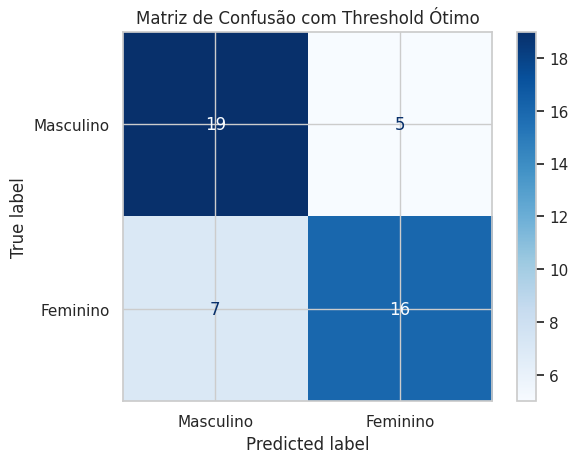

In [ ]:
# Garantir que y_test seja numérico
y_test_numeric = y_test  # Valores já estão em formato numérico

# Calcular probabilidades contínuas a partir do modelo
probs = model.predict(X_test).ravel()

# Calcular ROC-AUC
roc_auc = roc_auc_score(y_test_numeric, probs)
print(f"ROC-AUC: {roc_auc:.2f}")

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test_numeric, probs)
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.show()

# Encontrar o Threshold Ótimo (maximizar TPR - FPR)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Threshold Ótimo: {optimal_threshold:.2f}")

# Aplicar o Threshold Ótimo
y_pred_optimal = (probs >= optimal_threshold).astype(int)

# Relatório de Classificação com o Threshold Ótimo
print("\nRelatório de Classificação com Threshold Ótimo:")
print(classification_report(y_test_numeric, y_pred_optimal, target_names=["Masculino", "Feminino"]))

# Matriz de Confusão Gráfica
labels = ["Masculino", "Feminino"]
conf_matrix = confusion_matrix(y_test_numeric, y_pred_optimal)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
disp.plot(cmap="Blues", colorbar=True)

# Título personalizado para a matriz de confusão
plt.title("Matriz de Confusão com Threshold Ótimo")
plt.show()

